<a href="https://colab.research.google.com/github/the-bucketless/bdc/blob/main/bdc_tracking_animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animation Example for BDC Tracking Data

This is intended as a quick example of how you can use the [hockey rink](https://github.com/the-bucketless/hockey_rink) package to create animations with the [Big Data Cup tracking data](https://github.com/bigdatacup/Big-Data-Cup-2021/tree/main/TrackingData).  
We'll start by installing the package.

In [1]:
!pip install hockey-rink

  Created wheel for hockey-rink: filename=hockey_rink-0.1.6-py3-none-any.whl size=34688 sha256=2eb15c2c05a3046a26aa23f91b27c7f400a922143497ad6d0207dd05c730fc72
  Stored in directory: /root/.cache/pip/wheels/8d/84/a1/c6810468585880653548efcb0dc38ed3a8987efc5f6d3c52b7
Successfully built hockey-rink


I recently added a rink specifically for the Big Data Cup, so that's what we'll work with.  

Additionally, we'll need:
- Image from IPython.display to view the gif of our animation
- pandas to grab the csv
- tqdm to give us a progress bar
- matplotlib to do the actual work on the animation

In [2]:
from hockey_rink import BDCRink

from IPython.display import Image
import pandas as pd
from tqdm import tqdm

from matplotlib import rc
import matplotlib.animation as animation
import matplotlib.pyplot as plt

rc("animation", html="html5")

Seeing as I've spent so much time cleaning the data, let's grab a file from my [repo](https://github.com/the-bucketless/bdc/tree/main/data). You can change the values here to whatever file you want to work with, though you should make sure it's available.

In [3]:
game_name = "2022-02-14 USA at Finland" #@param ["2022-02-08 Canada at USA", "2022-02-08 ROC at Finland", "2022-02-12 Switzerland at ROC", "2022-02-14 USA at Finland", "2022-02-14 Switzerland at Canada", "2022-02-16 Switzerland at Finland"]
period = 3 #@param {type: "integer"}
penalty_number = 5 #@param {type: "integer"}

In [4]:
repo_game = game_name.replace(" ", "%20")
df = pd.read_csv(
    "https://raw.githubusercontent.com/the-bucketless/bdc/main/data/"
    f"{repo_game}/{repo_game}%20P{period}%20PP{penalty_number}.csv"
)

Because I added the rink to the package, we shouldn't need to update any of its parameters.

In [5]:
rink = BDCRink()

Before we do the animation, we'll do a plot to see what we're going for. The plot should have colored dots for each player on each team with jersey numbers alongside them. We'll ensure coordinates stay within the bounds of the rink, though they could end up outside if they're in the corners.  

In [6]:
light_jersey = "white" #@param {type: "string"}
dark_jersey = "blue" #@param {type: "string"}

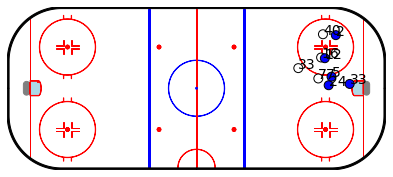

In [7]:
team_colors = {"Light": light_jersey, "Dark": dark_jersey}

# using the first frame_id of the given dataframe
frame_df = df.loc[df.frame_id == df.frame_id.iloc[0], :]

xs = frame_df.x_ft.clip(lower=0, upper=200)
ys = frame_df.y_ft.clip(lower=0, upper=85)
color = frame_df.team_id.map(team_colors)
txts = frame_df.jersey_number

fig = plt.figure(figsize=(7, 3))
ax = rink.draw()
rink.scatter(xs, ys, c=color, s=80, edgecolor="black", is_constrained=False, zorder=101);
for x, y, txt in zip(xs, ys, txts):
    ax.text(*rink.convert_xy(x, y), txt, fontsize=14, zorder=102)

To make this an animation, we pretty much just take the above and wrap it in the animation function so it can do multiple frames. To save time, we're going to avoid re-drawing the rink at each update. Instead of clearing everything on the Axes, we'll keep track of the scatterplot elements with a global variable which we'll remove at the subsequent update. We'll also clear all text objects from the Axes at each step.

In [8]:
fig = plt.figure(figsize=(7, 3))
fig.set_facecolor("white")
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

ax = rink.draw()

scatter = None


def update(frame_id):
    global scatter

    # remove the previous scatter plot
    if scatter is not None:
        scatter.remove()

    # remove any text previously added to the plot
    ax.texts = []

    frame_df = df.loc[df.frame_id == frame_id, :]
    xs = frame_df.x_ft.clip(lower=0, upper=200)
    ys = frame_df.y_ft.clip(lower=0, upper=98)
    color = frame_df.team_id.map(team_colors)
    txts = frame_df.jersey_number

    scatter = rink.scatter(
        xs, ys, c=color, edgecolor="black", s=80, 
        is_constrained=False, zorder=101, ax=ax
    )

    for x, y, txt in zip(xs, ys, txts):
        ax.text(*rink.convert_xy(x, y), txt, fontsize=14, zorder=102)

plt.close()

Before creating the animation, we can set a couple more parameters.
- fps: frames per second. To use all the frames available, set this to 30. The higher the fps, the longer it'll take for things to run.
- filename: for saving the animation as a gif. This won't save it locally, there'll be an option to download the file at the end of the notebook.
- video_shot: if you don't want to include all video shots in the dataframe, set this to the one you want to use. To use all video shots, set this to 0 (or any value not found in the dataframe).


In [18]:
fps = 6 #@param {type: "integer"}
filename = "bdc_animation_example" #@param {type: "string"}
video_shot = 0 #@param {type: "integer"}

All right, we're ready to create the actual animation. We're going to save it as a gif which we'll view once it's created. I've included a progress bar to see how long things will take.

In [16]:
video_shots = df.video_shot.unique()
if video_shot in video_shots:
    video_shots = [video_shot]

step = 30 // fps
frames = (
    df.loc[df.video_shot.isin(video_shots), "frame_id"]
    .unique()
    [::step]
)

writer = animation.PillowWriter(fps=fps)
anim = animation.FuncAnimation(fig, update, frames=frames, interval=1000 / fps)

bar = tqdm(total=len(frames))
anim.save(f"{filename}.gif", writer=writer, progress_callback=lambda i, n: bar.update(1))
bar.close()

100%|██████████| 183/183 [00:19<00:00,  9.29it/s]


Finally, let's see what it looks like.

In [19]:
Image(open(f"{filename}.gif", "rb").read())

If you want a play/pause button or to download the file as an mp4, uncomment and run this cell (download by clicking on the three dots in the bottom right corner of the animation).

In [12]:
# anim

If you want to save the gif, you can either
- Find it in the files section to the left.  
or
- Check the checkbox and run the following cells.

In [13]:
is_saving = False #@param {type: "boolean"}

In [14]:
if is_saving:
    from google.colab import files
    files.download(f"{filename}.gif")